# 过度拟合

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

# 过度拟合是什么?

在构建模型时，我们通过拟合样本数据来调整参数和模型。然后我们使用模型和参数来预测我们尚未观察到的数据。当一个模型对样本数据中的噪声和特性过于敏感，因此不能反映底层的数据生成过程时，我们就说这个模型是过度拟合的。

要理解为什么会发生这种情况，必须考虑任何数据集中存在的噪声量。可以将一组数据看作$D_{T}$，它是来自我们要建模的任何进程的真实底层数据，还有$\epsilon$，一些随机噪声。因为我们看到的是$D = D_{T} + \epsilon$，所以我们的模型可以非常完美地预测给定的$D \epsilon$，但是不能预测$D_{T}$。

这是有问题的，因为我们只关心样本的拟合，只要它能精确地拟合未来的数据。过度拟合的两个主要原因是:
* 样本容量小，使噪音和趋势无法分辨
* 选择一个过于复杂的模型，这样它最终会扭曲以拟合样本中的噪声

## 口头例子:太多的规则(复杂性)

假设你有以下数据集:

| TV Channel | Room Lighting Intensity | Enjoyment |
|------------|-------------------------|-----------|
| 1          | 2                       | 1         |
| 2          | 3                       | 2         |
| 3          | 1                       | 3         |

你试图预测享受度，所以你创造了以下规则:

1. 如果电视频道为1，灯光强度为2，那么享受度为1。
2. 如果电视频道为2，灯光强度为3，则享受度为2。
3. 如果电视频道为3，灯光强度为1，则享受度为3。
4. 在所有其他情况下，预测平均享受2。

这是一个定义良好的未来数据模型，然而，在这种情况下，我们假设你的享受完全依赖于电视频道，而不是灯光。因为我们对数据集中的每一行都有一个规则，所以我们的模型在历史数据中具有完美的预测性，但在实际试验中却表现不佳，因为我们对照明强度数据中的随机噪声进行了过度拟合。

将此推广到股票，如果您的模型开始基于特定的过去事件开发许多特定的规则，那么它几乎肯定是过度拟合的。这就是为什么黑箱机器学习(神经网络等)在不正确的情况下是如此危险。

# 例如:曲线拟合

当我们研究多项式回归时，过拟合是最容易看到的。下面我们构造一个噪声服从二次型的数据集。线性模型存在拟合不足:简单的线性模型并不适用于所有情况，特别是当我们有理由相信数据是非线性的时候。二次曲线虽有误差，但与实际数据吻合较好。

当我们将一个九次多项式与数据拟合时，误差为零——一个九次多项式可以通过任意10个点——但是，观察曲线的尾部，我们知道我们不能指望它准确地预测来自相同分布的其他样本。它完全符合数据，但那是因为它也完全符合噪音，而噪音不是我们想要建模的。在这种情况下，我们选择了一个过于复杂的模型。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from scipy import poly1d

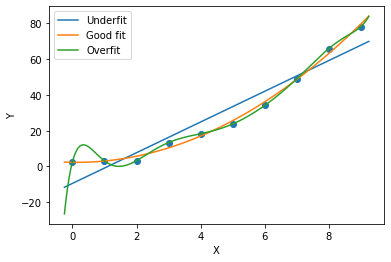

In [2]:
x = np.arange(10)
y = 2*np.random.randn(10) + x**2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

plt.scatter(x, y)
plt.plot(xs, poly1d(lin)(xs))
plt.plot(xs, poly1d(quad)(xs))
plt.plot(xs, poly1d(many)(xs))
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(['Underfit', 'Good fit', 'Overfit']);

在处理真实数据时，不太可能出现九次多项式合适的情况:我们对函数的选择应该反映出对底层过程的一种信念，而现实世界的过程通常不遵循高次多项式曲线。这个例子是人为的，但它可能是诱人的使用二次或三次模型，只是为了减少样本误差。

## 注意:模型/参数吝啬

就像最优雅的物理模型通过几个方程式来描述我们世界的大量信息一样，一个好的交易模型应该通过一些规则来解释大部分数据。任何时候，当你开始有一些规则甚至接近你的数据集中的点的数量时，你可以确定你是过度拟合了。由于可以将参数视为规则，因为它们等同于约束模型，所以参数也是如此。参数越少越好，2-3个参数解释60%的数据比10个参数解释90%的数据更好。

## 小心完美拟合

因为在真实数据中几乎总是存在噪声，所以完美的拟合几乎总是预示着过度拟合。在开发模型时，几乎不可能知道给定数据集中的噪音/信号百分比，但是可以使用常识。这些预测出乎意料的好吗?那你可能是过度拟合了。

# 例如:回归参数

我们如何知道模型中应该包含哪些变量?如果我们害怕漏掉一些重要的东西，我们可能会尝试不同的方法，包括所有我们能找到的变量来提高适合度。下面，我们将回归一种资产，它与我们试图预测其价格的资产在同一部门，以及另外三种不相关的资产。在我们的初始时间框架中，当使用多个变量时，我们能够使模型比只使用一个变量时更接近于数据。

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


SLR R-squared: 0.7210958466385327
SLR p-value: 1.7286342670290979e-71
MLR R-squared: 0.8181280172275107
MLR p-value: 5.367002720598651e-91


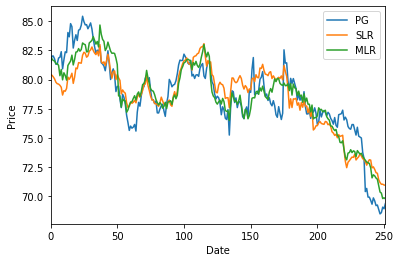

In [4]:
from pandas_datareader import data
# Load one year's worth of pricing data for five different assets
start = '2013-01-01'
end = '2014-01-01'
# x1 = data.get_data_yahoo('PEP', start, end)['Close']
# x2 = data.get_data_yahoo('MCD', start, end)['Close']
# x3 = data.get_data_yahoo('ATHN', start, end)['Close']
# x4 = data.get_data_yahoo('DOW', start, end)['Close']
# y = data.get_data_yahoo('PG', start, end)['Close']
x1=pd.read_csv('PEP.csv')['收盘']
x2=pd.read_csv('MCD.csv')['收盘']
x3=pd.read_csv('ATHN.csv')['收盘']
x4=pd.read_csv('DOW.csv')['收盘']
y=pd.read_csv('PG.csv')['收盘']
# Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print( 'SLR R-squared:', slr.rsquared_adj)
print( 'SLR p-value:', slr.f_pvalue)
print('MLR R-squared:', mlr.rsquared_adj) 
print('MLR p-value:', mlr.f_pvalue) 

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

然而，当我们使用相同的估计参数来对不同的时间段进行建模时，我们发现单变量模型拟合度较差，而多变量模型则完全没用。似乎我们发现的关系是不一致的，而且只适用于原始样本时期。

SLR R-squared: 0.4275631372158625
MLR R-squared: -0.00995195886061806


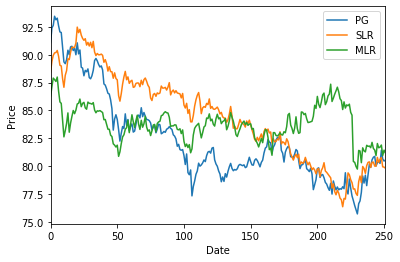

In [5]:
# Load the next of pricing data
start = '2014-01-01'
end = '2015-01-01'
x1=pd.read_csv('PEP2.csv')['收盘']
x2=pd.read_csv('MCD2.csv')['收盘']
x3=pd.read_csv('ATHN2.csv')['收盘']
x4=pd.read_csv('DOW2.csv')['收盘']
y=pd.read_csv('PG2.csv')['收盘']

# Extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Manually compute adjusted R-squared over the new time period

# Adjustment 1 is for the SLR model
p = 1
N = len(y)
adj1 = float(N - 1)/(N - p - 1)

# Now for MLR
p = 4
N = len(y)
adj2 = float(N - 1)/(N - p - 1)

SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print('SLR R-squared:', 1 - adj1*SSRs/SST) 
SSRm = sum((mlr_prediction2 - y)**2)
print( 'MLR R-squared:', 1 - adj2*SSRm/SST)

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

如果我们愿意，我们可以扫描我们的宇宙寻找与因变量相关的变量，并构建一个极度过度拟合的模型。然而，在大多数情况下，这种相关性是虚假的，并且这种关系不会持续到未来。

# 例子:滚动窗口

在构建使用滚动参数估计(如滚动平均值或滚动beta)的模型时，一个挑战是选择窗口长度。较长的窗口期将考虑长期趋势，波动性较小，但在考虑新观察结果时，窗口期也会更滞后。窗口长度的选择对滚动参数估计有很大的影响，可以改变我们对数据的观察和处理方式。下面我们计算不同窗口长度下股票价格的移动平均值:

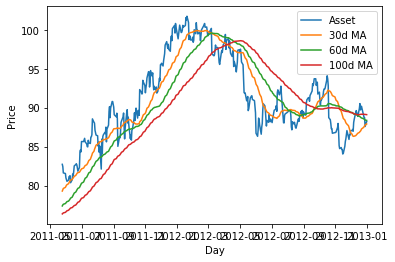

In [6]:
# Load the pricing data for a stock
start = '2011-01-01'
end = '2013-01-01'
pricing = data.get_data_yahoo('MCD', start,end)['Close']

# Compute rolling averages for various window lengths
mu_30d = pricing.rolling(window=30).mean()
mu_60d = pricing.rolling(window=60).mean()
mu_100d = pricing.rolling(window=100).mean()

# Plot asset pricing data with rolling means from the 100th day, when all the means become available
plt.plot(pricing[100:], label='Asset')
plt.plot(mu_30d[100:], label='30d MA')
plt.plot(mu_60d[100:], label='60d MA')
plt.plot(mu_100d[100:], label='100d MA')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend();

如果我们根据哪个长度看起来最好进行选择,比如，我们的模型或算法表现如何,那就是过度拟合了。下面我们有一个简单的交易算法，它押注股价回归到滚动平均(更多细节，请查看均值回归笔记本)。利用该算法的性能对窗口长度进行评分，找出最佳窗口长度。然而，当我们考虑一个不同的时间段时，这个窗口长度远远不是最优的。这是因为我们最初的选择是对样本数据的过度拟合。

In [7]:
# Trade using a simple mean-reversion strategy
def trade(stock, length):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0
    
    # Compute rolling mean and rolling standard deviation
    rolling_window = stock.rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()
    
    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock - mu)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    count = 0
    for i in range(len(stock)):
        # Sell short if the z-score is > 1
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        # Buy long if the z-score is < 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            money += count*stock[i]
            count = 0
    return money

In [8]:
# Find the window length 0-254 that gives the highest returns using this strategy
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print('Best window length:', best_length) 

Best window length: 11


In [12]:
# Get pricing data for a different timeframe
start2 = '2013-01-01'
end2 = '2015-01-01'
pricing2 = data.get_data_yahoo('MCD', start2,end2)['Close']

# Find the returns during this period using what we think is the best window length
length_scores2 = [trade(pricing2, l) for l in range(255)]
print(best_length, 'day window:', length_scores2[best_length]) 

# Find the best window length based on this dataset, and the returns using this window length
best_length2 = np.argmax(length_scores2)
print(best_length2, 'day window:', length_scores2[best_length2]) 

11 day window: 42.189918518066406
189 day window: 471.2797088623047


显然，与我们的样本数据相吻合并不总是能在未来得出好的结果。为了好玩，我们来画出从两个不同时间段计算出来的长度分数:

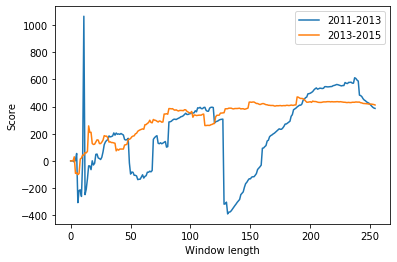

In [13]:
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['2011-2013', '2013-2015']);

为了避免过度拟合，我们可以使用经济推理或算法的性质来选择窗口长度。我们还可以使用卡尔曼滤波器，它不需要我们指定长度;这个方法包含在另一个笔记本中。

# 避免过度拟合

通过选取大样本，选择合理简单的模型，不选取参数来拟合数据，可以避免过度拟合;但是仅仅运行两个回测就已经是过度拟合了。

## 样本检验之外

为了确保我们没有打破我们的模型与过度拟合，我们必须样本外。也就是说，我们需要收集在构建模型时没有使用的数据，并测试我们的模型是否继续工作。如果我们不能随意收集大量的额外数据，我们应该把我们的样本分成两部分，其中一部分只用于测试。

### 常见错误:滥用样本外数据

有时人们会在样本内数据上构建模型，在样本外数据上进行测试，然后得出结论:它不起作用。然后他们将重复这个过程，直到他们找到一个可行的模型。这仍然是过度拟合，因为您没有通过多次使用模型来过度拟合样本外数据，而且当您实际测试真正的样本外数据时，您的模型可能会崩溃。
### 交叉验证

交叉验证是将数据分成n个部分，然后对n-1个部分的最优参数进行估计，最后对最后一部分进行测试的过程。这样做n次，每个部分1次，我们就可以确定我们的参数估计值有多稳定，以及它们对非原始数据集的预测有多好。

## 信息标准

信息标准是一种严格的统计方法，用于测试模型中的复杂性是否值得额外的预测能力。该测试支持更简单的模型，并将告诉您是否引入了大量的复杂性而没有得到多少回报。最常见的方法之一是[Akaike Information Criterion.](https://en.wikipedia.org/wiki/Akaike_information_criterion)。